In [2]:
from bs4 import BeautifulSoup as bs #import libraries needed
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist


In [ ]:
#This will scrap the district table from Wikipedia
#----------------------------------------------------------
url='https://en.wikipedia.org/wiki/Districts_of_Hong_Kong'
response = requests.get(url)
soup = bs(response.text, 'html.parser')
table = soup.find('table',{'class':'wikitable sortable'}).tbody #grab the table content
rows = table.find_all('tr') #identify the rows
columns = [v.text.replace('\n','') for v in rows[0].find_all('th')]#indentify the columns' name from the first row
df=pd.DataFrame(columns=columns) #produce the dataframe from pandas
for i in range(1, len(rows)): #read the contents of each row
    tds = rows[i].find_all('td')
    if len(tds) ==4:
        values = [tds[0].text, tds[1].text,tds[2].text.replace('\n','')]
    else:
        values = [td.text .replace('\n','') for td in tds]
    df = df.append(pd.Series(values, index = columns), ignore_index = True)#insert the values into the data frame

In [4]:
#drop irrelevant columns 
#----------------------------------------------------------
df=df.drop(['Chinese','Population [6]','Area(km²)','Density(/km²)','Region'],axis=1) 

In [5]:
#show the first row
#----------------------------------------------------------
df.head(1) 


,District
0,Central and Western


In [6]:
#import the location of districts
#----------------------------------------------------------
a=[]
b=[]
for i in range(df.shape[0]):
    address = (str(df['District'][i])+', Hong Kong, China')
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    a.append(latitude)
    b.append(longitude)
a[1]= 22.279594
a[2]= 22.247692
a[9]= 22.289997
a[11]= 22.497353
b[1]= 114.232420
b[2]= 114.154762
b[9]= 113.943162
b[11]= 114.132719
df['latitude']=a
df['longitude']=b


In [7]:
# show the cleaned data
#----------------------------------------------------------
df

,District,latitude,longitude
0,Central and Western,22.285239,114.150679
1,Eastern,22.279594,114.232420
2,Southern,22.247692,114.154762
3,Wan Chai,22.277465,114.173026
4,Sham Shui Po,22.330095,114.160940
5,Kowloon City,22.331013,114.190366
6,Kwun Tong,22.312126,114.226501
7,Wong Tai Sin,22.342063,114.194388
8,Yau Tsim Mong,22.307453,114.165202
9,Islands,22.289997,113.943162


In [8]:
#show map in hong kong with 18 district spots
#----------------------------------------------------------

address = 'Hong Kong, China'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #find hong kong location
HK_latitude = location.latitude
HK_longitude = location.longitude

map_HongKong = folium.Map(location=[HK_latitude+0.1, HK_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, dis in zip(df['latitude'], df['longitude'], df['District']):
    label = folium.Popup(str(dis), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_HongKong)
       
map_HongKong 

In [9]:
CLIENT_ID='STAAEV31ZRBNPJ5IARPEX5DMXL5R5JLG4PZLKUOPQPIUG0WU'
CLIENT_SECRET='ZLFKSFKOLYII3HL4OKMZV30RFURJ3PZGJNSTDPWXITLF3NZQ'
VERSION='20181201'
LIMIT = 1000
radius=1000
def getNearbyVenues(names, latitudes, longitudes): #def a function to get venues of each districts within 1000m
    venues_list=[]

    for dis, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']


        venues_list.append([(
            dis, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)



In [10]:
#create a new table of all venues in each district
#----------------------------------------------------------
HK_venues = getNearbyVenues(names=df['District'], 
                                latitudes=df['latitude'],
                                longitudes=df['longitude']
                                )

In [11]:
HK_venues

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central and Western,22.285239,114.150679,La Crêperie,22.285252,114.150978,Creperie
1,Central and Western,22.285239,114.150679,Ronin,22.284525,114.152430,Japanese Restaurant
2,Central and Western,22.285239,114.150679,Te Quiero Mucho,22.284711,114.150643,Mexican Restaurant
3,Central and Western,22.285239,114.150679,Monsieur Chatté,22.286218,114.150621,Wine Shop
4,Central and Western,22.285239,114.150679,Coco Espresso,22.285117,114.152466,Coffee Shop
5,Central and Western,22.285239,114.150679,Yardbird,22.287076,114.149177,Japanese Restaurant
6,Central and Western,22.285239,114.150679,PMQ (元創方),22.283298,114.151971,Art Gallery
7,Central and Western,22.285239,114.150679,VEA Restaurant and Bar,22.284890,114.152953,French Restaurant
8,Central and Western,22.285239,114.150679,Sang Kee Congee Shop (生記粥品專家),22.285321,114.151552,Chinese Restaurant
9,Central and Western,22.285239,114.150679,Cupping Room,22.285111,114.150484,Café


In [12]:
#count the venues no. in each district
#----------------------------------------------------------
HK_venues.groupby('District').count() 

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Central and Western,100,100,100,100,100,100
Eastern,47,47,47,47,47,47
Islands,44,44,44,44,44,44
Kowloon City,85,85,85,85,85,85
Kwai Tsing,14,14,14,14,14,14
Kwun Tong,89,89,89,89,89,89
North,22,22,22,22,22,22
Sai Kung,59,59,59,59,59,59
Sha Tin,95,95,95,95,95,95


In [13]:
# one hot encoding
#----------------------------------------------------------
HK_onehot = pd.get_dummies(HK_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#----------------------------------------------------------
HK_onehot['District'] = HK_venues['District'] 

# move neighborhood column to the first column
#----------------------------------------------------------
fixed_columns = [HK_onehot.columns[-1]] + list(HK_onehot.columns[:-1])
HK_onehot = HK_onehot[fixed_columns]
HK_grouped = HK_onehot.groupby('District').mean().reset_index() 

In [14]:
#calculate the frequency of each type of venue in each district, sorted descending
#----------------------------------------------------------
num_top_venues = 5

for hood in HK_grouped['District']: 
    print("----"+hood+"----")
    temp = HK_grouped[HK_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n') 

----Central and Western----
                 venue  freq
0                 Café  0.09
1  Japanese Restaurant  0.06
2          Coffee Shop  0.06
3   Italian Restaurant  0.05
4   Chinese Restaurant  0.05


----Eastern----
                  venue  freq
0  Fast Food Restaurant  0.11
1          Noodle House  0.06
2    Chinese Restaurant  0.06
3        Cha Chaan Teng  0.04
4          Dessert Shop  0.04


----Islands----
               venue  freq
0        Coffee Shop  0.09
1  Accessories Store  0.05
2               Café  0.05
3   Sushi Restaurant  0.05
4     Clothing Store  0.05


----Kowloon City----
                venue  freq
0     Thai Restaurant  0.13
1        Dessert Shop  0.13
2  Chinese Restaurant  0.08
3         Coffee Shop  0.06
4                Café  0.05


----Kwai Tsing----
                  venue  freq
0                 Hotel  0.21
1         Grocery Store  0.14
2  Fast Food Restaurant  0.14
3                Tunnel  0.14
4     Convenience Store  0.14


----Kwun Tong----
        

In [15]:
def return_most_common_venues(row, num_top_venues): #fill only the venues with high frequency
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
HK_venues_sorted = pd.DataFrame(columns=columns)
HK_venues_sorted['District'] = HK_grouped['District']

for ind in np.arange(HK_grouped.shape[0]):
    HK_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HK_grouped.iloc[ind, :], num_top_venues)

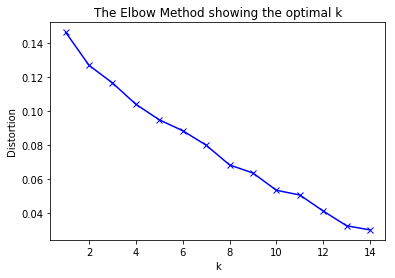

In [16]:
#calculate the distortion for each K 
#----------------------------------------------------------
distortions = []
K = range(1,15) #set the range of K for test
HK_grouped_clustering = HK_grouped.drop('District', 1)
for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(HK_grouped_clustering)
    kmeanModel.fit(HK_grouped_clustering)
    distortions.append(sum(np.min(cdist(HK_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / HK_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')#plot the distortion for each K
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [17]:
#set the K as the optimal K
#----------------------------------------------------------
kclusters = 4 

HK_grouped_clustering = HK_grouped.drop('District', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(HK_grouped_clustering)

kmeans.labels_[0:10]

array([1, 0, 1, 0, 3, 0, 2, 1, 0, 0], dtype=int32)

In [18]:
#insert the cluster labels for each district
#----------------------------------------------------------
HK_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

HK_merged=df

HK_merged = HK_merged.join(HK_venues_sorted.set_index('District'), on='District')


In [19]:
# create map with the 4 clusters
#----------------------------------------------------------
map_clusters = folium.Map(location=[HK_latitude, HK_longitude], zoom_start=11)

# set color scheme for the clusters
#----------------------------------------------------------
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, dis, cluster in zip(HK_merged['latitude'], HK_merged['longitude'], HK_merged['District'], HK_merged['Cluster Labels']):
    label = folium.Popup(str(dis) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [20]:
#shows the table of the 10 most common venues in each district and their cluster no.
#----------------------------------------------------------
HK_merged

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,22.285239,114.150679,1,Café,Japanese Restaurant,Coffee Shop,Italian Restaurant,Chinese Restaurant,French Restaurant,Indian Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant,Cha Chaan Teng
1,Eastern,22.279594,114.232420,0,Fast Food Restaurant,Noodle House,Chinese Restaurant,Metro Station,Sporting Goods Shop,Park,Dumpling Restaurant,Cha Chaan Teng,Dessert Shop,Hong Kong Restaurant
2,Southern,22.247692,114.154762,0,Chinese Restaurant,Fast Food Restaurant,Hotel,Park,Shopping Mall,Seafood Restaurant,Furniture / Home Store,Sushi Restaurant,BBQ Joint,Coffee Shop
3,Wan Chai,22.277465,114.173026,1,Hotel,Chinese Restaurant,Café,Cantonese Restaurant,Coffee Shop,Bar,Thai Restaurant,Hong Kong Restaurant,Steakhouse,Spanish Restaurant
4,Sham Shui Po,22.330095,114.160940,0,Noodle House,Chinese Restaurant,Dessert Shop,Hong Kong Restaurant,Café,Fast Food Restaurant,Shopping Mall,Dumpling Restaurant,Coffee Shop,Hotpot Restaurant
5,Kowloon City,22.331013,114.190366,0,Dessert Shop,Thai Restaurant,Chinese Restaurant,Coffee Shop,Noodle House,Café,Fast Food Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Asian Restaurant
6,Kwun Tong,22.312126,114.226501,0,Chinese Restaurant,Café,Coffee Shop,Hong Kong Restaurant,Fast Food Restaurant,Japanese Restaurant,Cha Chaan Teng,Sushi Restaurant,Shopping Mall,Restaurant
7,Wong Tai Sin,22.342063,114.194388,0,Chinese Restaurant,Fast Food Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Shopping Mall,Noodle House,Coffee Shop,Café,Bus Station,Market
8,Yau Tsim Mong,22.307453,114.165202,1,Hotel,Chinese Restaurant,Dessert Shop,Café,Noodle House,Coffee Shop,Dim Sum Restaurant,Indian Restaurant,Seafood Restaurant,Japanese Restaurant
9,Islands,22.289997,113.943162,1,Coffee Shop,Accessories Store,Café,Sporting Goods Shop,Fast Food Restaurant,Clothing Store,Sushi Restaurant,Park,Hotel Bar,New American Restaurant
